In [1]:
import mat73
import pandas as pd
import numpy as np
import scipy.io
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

### Data loading

In [2]:
import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()):
    if "anuja" in os.environ.get('USER'):
        DATA_DIR = 'data/'
    elif 'ubuntu' in os.environ.get('USER'):
        DATA_DIR = '/home/ubuntu/Martyna/repo/AI4Health/DATAfoof/'
    

In [3]:
path = os.path.join(DATA_DIR, 'split_data')
#loading
train_features = pd.read_pickle(os.path.join(path, 'train_features_sensor.pkl'))
test_features = pd.read_pickle(os.path.join(path, 'test_features_sensor_classification.pkl'))
train_labels = pd.read_pickle(os.path.join(path, 'train_labels_classification.pkl'))
test_labels = pd.read_pickle(os.path.join(path, 'test_labels_classification.pkl'))

train_features = np.array(train_features)
test_features = np.array(test_features)
train_labels = np.array(train_labels) 
test_labels = np.array(test_labels) 

## FEATURE EXTRACTION WITH PCA

In [4]:
age_gender = True
if age_gender:
    train_age_gender = train_features[:,-2:]
    test_age_gender = test_features[:,-2:]
    train_features = train_features[:,:-2]
    test_features = test_features[:,:-2]

In [5]:
#scaling features

# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(train_features)

# transform training data
train_features = norm.transform(train_features)
test_features = norm.transform(test_features)

print(train_features.shape, test_features.shape)

(1440, 4305) (481, 4305)


## PCA

In [6]:
# dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(.95) # 95% variance retained
pca.fit(train_features)

# transform data
train_features = pca.transform(train_features)
test_features = pca.transform(test_features)
print(train_features.shape, test_features.shape)

(1440, 234) (481, 234)


In [7]:
if age_gender:
    train_features = np.concatenate([train_features, train_age_gender], axis = 1)
    test_features = np.concatenate([test_features, test_age_gender], axis = 1)

### Metrics

In [8]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, PrecisionRecallDisplay
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

n_classes = train_labels.shape[1]

def plot_pr_curve(Y_test, y_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict() #actually stores AUC
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
#         average_precision[i] = auc(recall[i], precision[i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])
#         average_precision[i] = auc(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        Y_test.ravel(), y_score.ravel()
    )
#     average_precision["micro"] = auc(recall["micro"], precision["micro"])
    average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

#     average_precision["macro"] = np.average(list(average_precision.values()))

    _, ax = plt.subplots(figsize=(8, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i in range(n_classes):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}")

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Precision-Recall curve")
    plt.show()
    
    return average_precision["micro"]
    
def plot_roc_curve(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
   
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#     roc_auc["macro"] = np.average(list(roc_auc.values()))
    
    # Plot ROC curve
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operator characteristics')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc["micro"]

In [9]:
from sklearn.metrics import hamming_loss, accuracy_score
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

def brier_multi(targets, probs):
    return np.mean(np.mean((probs - targets)**2, axis=1))

def evaluate(y_test, y_pred_prob, brier=True):
    y_pred = y_pred_prob.round()
    accuracy = accuracy_score(y_test, y_pred)
    hamming = hamming_loss(y_test, y_pred)
    brier_score = brier_multi(y_test, y_pred_prob)
    report = skm.classification_report(y_test,y_pred, zero_division=1, output_dict=True)
    
    print("Accuracy:", accuracy)
    print("Hamming Loss:", hamming)
    if brier:
        print("Brier Score:", brier_score)
    print("Classification Report:\n", skm.classification_report(y_test,y_pred, zero_division=1))
    print("Confusion matrix:\n", skm.multilabel_confusion_matrix(y_test, y_pred))
    
    return accuracy,  hamming, brier_score, report

## Models

In [10]:
model_names, model_names_all = [], []
accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc = [], [], [], [], [], [], [], []
accuracy_scores_all, hamming_all, brier_score_all, precision_all, recall_all, f1_score_all, pr_auc_all, roc_auc_all = [], [], [], [], [], [], [], []
accuracy_scores_std, hamming_std, brier_score_std, precision_std, recall_std, f1_score_std, pr_auc_std, roc_auc_std = [], [], [], [], [], [], [], []

def record_values(a, h, b, p, r, f, pr, roc,a_std, h_std, b_std, p_std, r_std, f_std, pr_std, roc_std, model_name=''):
    accuracy_scores.append(a)
    hamming.append(h)
    brier_score.append(b)
    precision.append(p)
    recall.append(r)
    f1_score.append(f)
    pr_auc.append(pr)
    roc_auc.append(roc)
    
    accuracy_scores_std.append(a_std)
    hamming_std.append(h_std)
    brier_score_std.append(b_std)
    precision_std.append(p_std)
    recall_std.append(r_std)
    f1_score_std.append(f_std)
    pr_auc_std.append(pr_std)
    roc_auc_std.append(roc_std)
    model_names.append(model_name)

def record_values_all(a, h, b, p, r, f, pr, roc, model_name=''):
    accuracy_scores_all.append(a)
    hamming_all.append(h)
    brier_score_all.append(b)
    precision_all.append(p)
    recall_all.append(r)
    f1_score_all.append(f)
    pr_auc_all.append(pr)
    roc_auc_all.append(roc)
    model_names_all.append(model_name)

In [11]:
def ci(vals):
    return np.percentile(vals, 5), np.percentile(vals, 95)

In [12]:
# specify runs here
n = 1

### Random Baseline

#### shuffling

In [13]:
%%capture

import sys, os

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    predicted_labels_shuffled = np.copy(test_labels)
    np.random.shuffle(predicted_labels_shuffled)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_shuffled)
    pr = plot_pr_curve(test_labels, predicted_labels_shuffled)
    roc = plot_roc_curve(test_labels, predicted_labels_shuffled)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Shuffling Baseline')
    

vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Shuffling Baseline')

### Always Zero Baseline

In [ ]:
%%capture

import sys, os

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    predicted_labels_always_zero = np.zeros_like(test_labels)
    # add noise
    noise = np.random.rand(test_labels.shape[0], test_labels.shape[1])
    predicted_labels_always_zero = predicted_labels_always_zero + 1e-4*noise
    
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_always_zero)
    pr = plot_pr_curve(test_labels, predicted_labels_always_zero)
    roc = plot_roc_curve(test_labels, predicted_labels_always_zero)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Always Zero Baseline')
    

vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Always Zero Baseline')

### Multi Output Classifier

In [ ]:
%%capture

from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)

forest = RandomForestClassifier() 
lg = LogisticRegression()
models = [lg, forest]
number_of_bootstraps = 10
seed_value = 7

for model in models:
    if str(model) == "RandomForestClassifier()":
        name = 'RandFor'  
    elif str(model) == "LogisticRegression()":
        name = 'LogReg'

    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []
    for i in range(n):

        multi_output_model = MultiOutputClassifier(model, n_jobs=-1)
        multi_output_model.fit(train_features, train_labels)

        # Boostrap
        resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

        predicted_labels = np.asarray(multi_output_model.predict_proba(resampled_xtest))[:, :, 1].T
        print(str(model)+':')
        accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels)
        pr = plot_pr_curve(resampled_ytest, predicted_labels)
        roc = plot_roc_curve(resampled_ytest, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)
        record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'MOC-'+str(name))
    
    
    vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
    means = [np.mean(v) for v in vals]
    cis = [ci(v) for v in vals]
    record_values(*means, *cis, 'MOC-'+str(name))

In [15]:
print(np.mean(a_avg), np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg), np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg))
accuracy_scores

0.10519750519750519 0.23983887733887732 1.3703499168399167 0.5935563646401126 0.2822718713867342 0.3825253371221109 0.48131960164704946 0.7127731635275081 0.018105231648297082 0.0058877090196745065 0.024519883743944777 0.02093694417574845 0.009716980775191007 0.012264229723665131 0.015018502096492036 0.009440402127137731


[0.04553014553014553, 0.08357588357588358, 0.10519750519750519]

### Label Powerset
takes correlations into account!

In [19]:
%%capture

from skmultilearn.problem_transform import LabelPowerset

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    classifier = LabelPowerset(LogisticRegression())
    classifier.fit(train_features, train_labels)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    
    predicted_labels_lp = classifier.predict_proba(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_lp.toarray())
    pr = plot_pr_curve(resampled_ytest, predicted_labels_lp.toarray())
    roc = plot_roc_curve(resampled_ytest, predicted_labels_lp.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'LP-LogReg')

    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'LP-LogReg')

In [20]:
%%capture

from sklearn.ensemble import RandomForestClassifier

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):

    classifier = LabelPowerset(RandomForestClassifier())
    classifier.fit(train_features, train_labels)

    predicted_labels_lp = classifier.predict_proba(test_features)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_lp.toarray())
    pr = plot_pr_curve(test_labels, predicted_labels_lp.toarray())
    roc = plot_roc_curve(test_labels, predicted_labels_lp.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'LP-RandFor')

    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'LP-RandFor')

In [21]:
print(np.mean(a_avg), np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg),np.std(a_avg), np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg))

0.10644490644490645 0.23781185031185031 1.346144033264033 0.5887246067508813 0.28471528471528473 0.3838095260906256 0.4777954845323274 0.717334983246469 0.0035768504228867472 0.0008808966349624866 0.003863404872198854 0.003531809218170227 0.0023640678453944563 0.002672660251009939 0.005789624413654288 0.0019864913726531587


### Visualisation

In [22]:
%matplotlib inline

[0.04553014553014553, 0.08357588357588358, 0.10519750519750519, 0.058212058212058215, 0.057380457380457384, 0.09438669438669439, 0.09833679833679834, 0.10644490644490645] [(0.035343035343035345, 0.054261954261954265), (0.06891891891891892, 0.09563409563409564), (0.07858627858627859, 0.13295218295218295), (0.03264033264033264, 0.07941787941787941), (0.041372141372141374, 0.07754677754677754), (0.0787941787941788, 0.11133056133056134), (0.08825363825363827, 0.1106029106029106), (0.10166320166320167, 0.11226611226611227)]


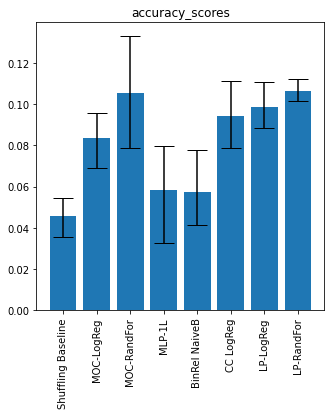

[0.3364345114345114, 0.25454781704781704, 0.23983887733887732, 0.28916320166320164, 0.30753638253638255, 0.256964656964657, 0.24415280665280664, 0.23781185031185031] [(0.329002079002079, 0.34667359667359665), (0.24694646569646572, 0.26212318087318087), (0.23261434511434514, 0.2494672557172557), (0.2746881496881497, 0.3014423076923077), (0.2943477130977131, 0.31379937629937626), (0.24725831600831605, 0.26327962577962577), (0.23286122661122663, 0.2531444906444906), (0.23700623700623702, 0.23951403326403325)]


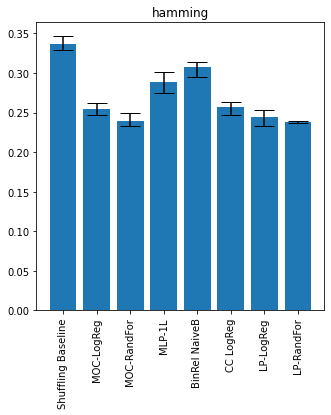

[2.6914760914760913, 1.451431471466526, 1.3703499168399167, 1.876989409103134, 1.7929157636354929, 1.4936278320238519, 1.4241225980097927, 1.346144033264033] [(2.632016632016632, 2.773388773388773), (1.4138208419263714, 1.4822688129472374), (1.3372870062370064, 1.4026770686070686), (1.8068247441183267, 1.9513484755759463), (1.7343565526001812, 1.8333608387150206), (1.4613587031408106, 1.5279330193476932), (1.3800730836380888, 1.4600000506466855), (1.3411383367983367, 1.3525395634095632)]


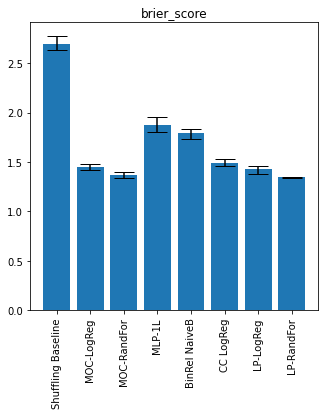

[0.3533466533466533, 0.5245297868252253, 0.5935563646401126, 0.44202274188502944, 0.4071420376812667, 0.5189984937972011, 0.5649049467220622, 0.5887246067508813] [(0.3336663336663337, 0.3676323676323676), (0.4981128294234386, 0.5482925835819417), (0.5597514607502753, 0.6172091247695819), (0.4122625168852674, 0.46749429945054943), (0.39517312395417686, 0.42127104978088536), (0.5014128514618791, 0.545970314576872), (0.5351834483669629, 0.590638888195346), (0.5820256153589487, 0.5918344961289747)]


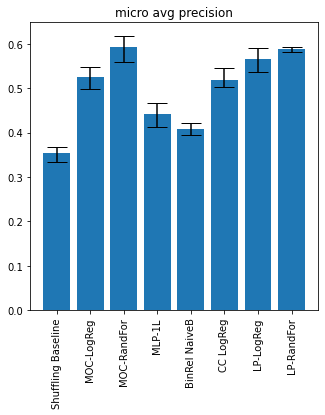

[0.3533466533466533, 0.3530754348219138, 0.2822718713867342, 0.3755713514703142, 0.3688932422020283, 0.3274187301923857, 0.3157519342179804, 0.28471528471528473] [(0.3336663336663337, 0.3676323676323676), (0.3358082971438735, 0.36981134451664904), (0.2654873935407707, 0.2914432160233232), (0.3421109091086806, 0.4016073248871414), (0.3530287984111221, 0.39492697996629844), (0.31007588372786293, 0.3421982081369304), (0.29291645051801574, 0.3398372781065089), (0.2811688311688312, 0.2882617382617383)]


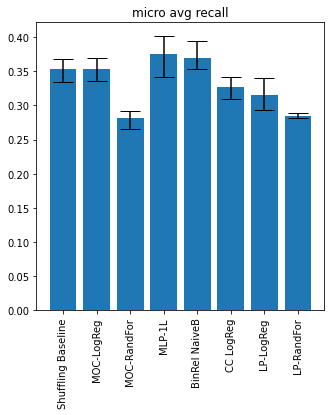

[0.3533466533466533, 0.42197802622224634, 0.3825253371221109, 0.4059541401040902, 0.3869493847962243, 0.4014121865269276, 0.4049161957133743, 0.3838095260906256] [(0.3336663336663337, 0.3676323676323677), (0.4011300425446832, 0.43832559409346394), (0.3632426124451126, 0.3957384411637842), (0.374497905863582, 0.42846857079071843), (0.3732004285558636, 0.4052074135079726), (0.38529019323197045, 0.4159674628905398), (0.379020194990097, 0.42839616628786514), (0.37924872058061454, 0.3873154362416107)]


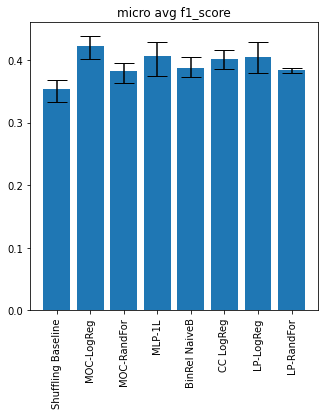

[0.2932098455450104, 0.4620549529942689, 0.48131960164704946, 0.41507843064042554, 0.38055753221047484, 0.441220561661191, 0.46582624291151653, 0.4777954845323274] [(0.2846700205591315, 0.2996545972320198), (0.44476276204723875, 0.47440568302582264), (0.4549196950073785, 0.4986843653227639), (0.3883330038408096, 0.43892414403918123), (0.3666170280910218, 0.3945745610422214), (0.42810688998659574, 0.4524537785354203), (0.4450104525621597, 0.47557238789489686), (0.47123876341524795, 0.4876428755731015)]


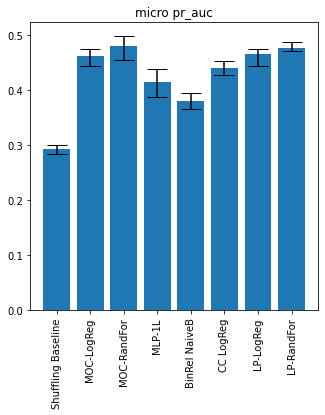

[0.5629922588826698, 0.7066575257543629, 0.7127731635275081, 0.6660465312248034, 0.6608397601751935, 0.6935532901271879, 0.7028552794676373, 0.717334983246469] [(0.5496923168156045, 0.5726465315506413), (0.6961179291830211, 0.7169055190780103), (0.6978671511338778, 0.7238343083902207), (0.6512183564314811, 0.6831531050710216), (0.6469120765601213, 0.6705775803786622), (0.6862805128255576, 0.6998157688433257), (0.6923777799355189, 0.714209858794558), (0.7143711837863577, 0.7202826502615753)]


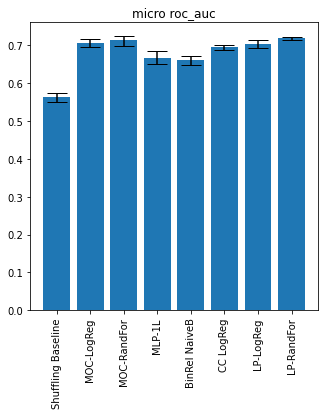

In [23]:
import matplotlib.pyplot as plt

score_names = ['accuracy_scores', 'hamming', 'brier_score', 'micro avg precision', 'micro avg recall', 'micro avg f1_score', 'micro pr_auc', 'micro roc_auc']
for scores, scores_std, score_name in zip([accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc],[accuracy_scores_std, hamming_std, brier_score_std, precision_std, recall_std, f1_score_std, pr_auc_std, roc_auc_std], score_names):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes([0,0,1,1])
    print(scores, scores_std)
    scores_std = np.array(list(zip(*scores_std)))
    scores_std[0] = scores - scores_std[0]
    scores_std[1] = scores_std[1] - scores
    ax.bar(model_names, scores, yerr = scores_std, capsize=10)
    plt.xticks(rotation='vertical')
    plt.title(score_name)
    plt.show()

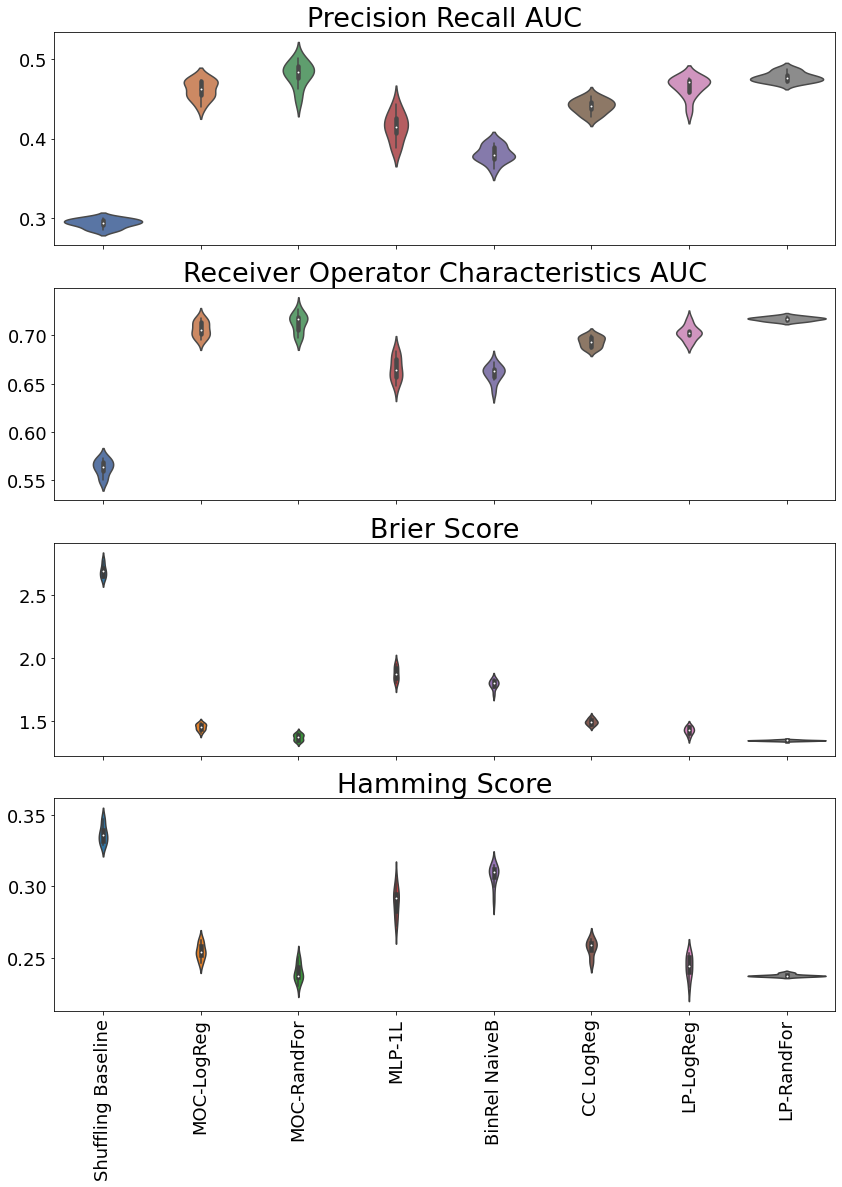

In [24]:
import seaborn as sns
#sns.set(style="whitegrid")

# plot
fig, axes = plt.subplots(4, 1, figsize=(14,18), sharex=True)
fig.suptitle("", fontsize = 25)
sns.violinplot(y=hamming_all, x=model_names_all, ax=axes[3])
axes[3].set_title('Hamming Score',fontsize = 27)
plt.xticks(fontsize=18)
axes[3].tick_params(axis='both', which='major', labelsize=18)


# plot
sns.violinplot(y=brier_score_all, x=model_names_all, ax=axes[2])
axes[2].set_title('Brier Score', fontsize = 27)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(3,16)})
sns.set(style="whitegrid")
plt.xticks(fontsize=18)
axes[2].tick_params(axis='y', which='major', labelsize=18)




# plot

sns.violinplot(y=pr_auc_all, x=model_names_all, ax=axes[0])
axes[0].set_title("Precision Recall AUC", fontsize =27)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(16,16)})
sns.set(style="whitegrid")
plt.xticks(fontsize=18)
axes[0].tick_params(axis='y', which='major', labelsize=18)




sns.violinplot(y=roc_auc_all, x=model_names_all, ax=axes[1])
axes[1].set_title("Receiver Operator Characteristics AUC", fontsize = 27)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(16, 16)})
sns.set(style="whitegrid")
plt.xticks(fontsize=18)
axes[1].tick_params(axis='y', which='major', labelsize=18)



# plt.show()

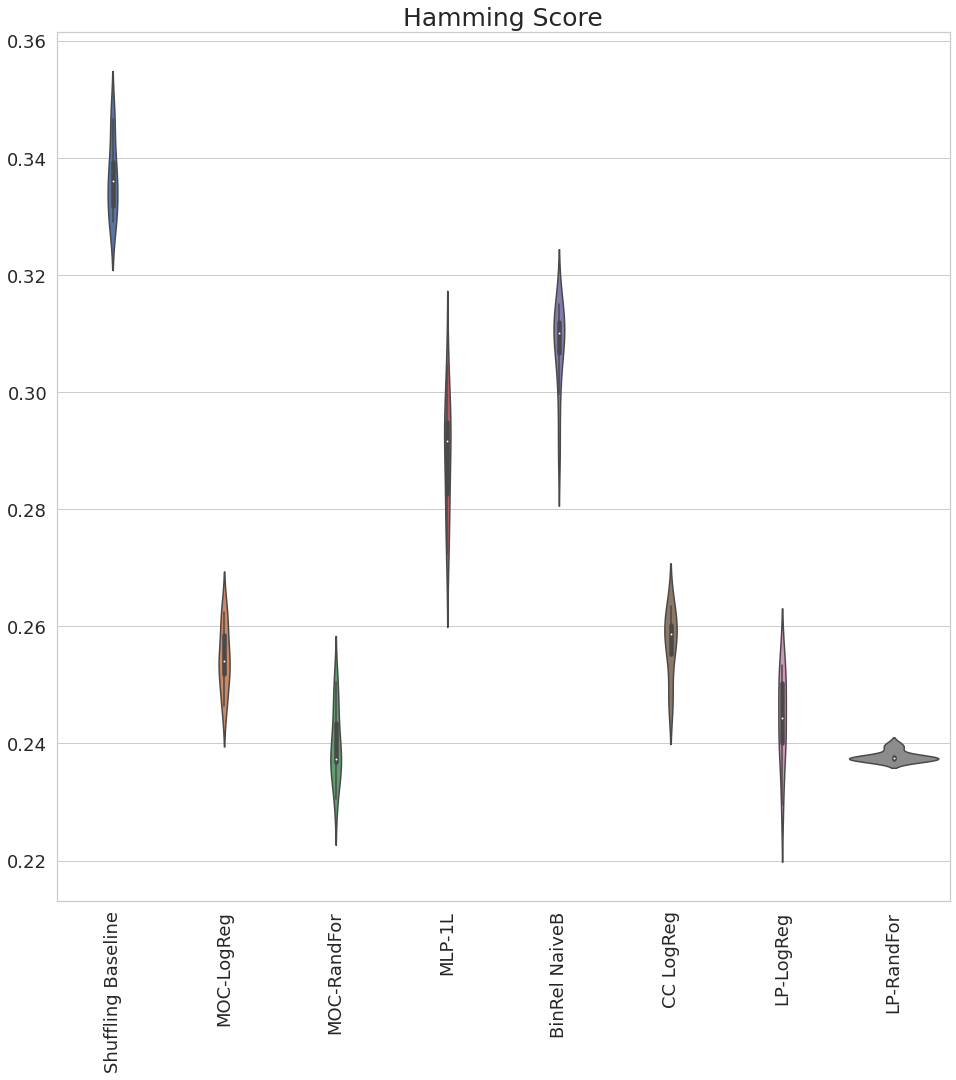

In [25]:
import seaborn as sns
#sns.set(style="whitegrid")

# plot
sns.violinplot(y=hamming_all, x=model_names_all)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(15, 8)})
plt.title("Hamming Score", fontsize = 25)
sns.set(style="whitegrid")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


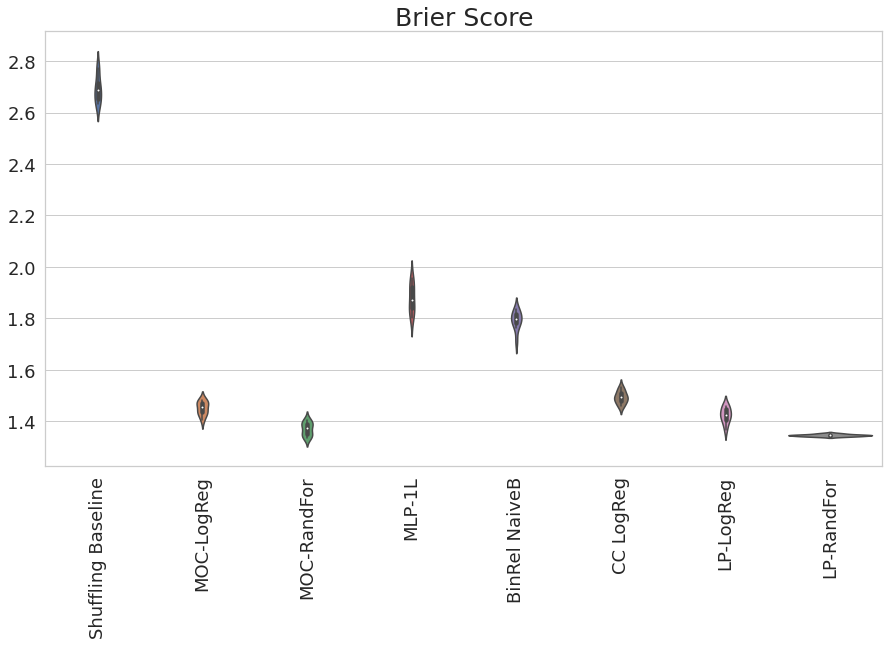

In [26]:

# plot
sns.violinplot(y=brier_score_all, x=model_names_all)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(15, 8)})
plt.title("Brier Score", fontsize = 25)
sns.set(style="whitegrid")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


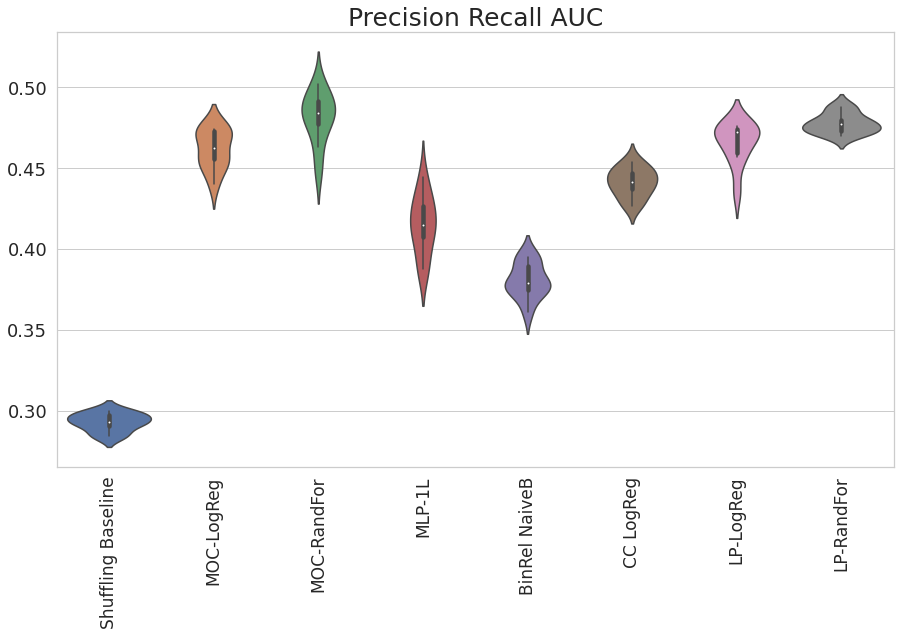

In [27]:

# plot
sns.violinplot(y=pr_auc_all, x=model_names_all)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(15, 8)})
plt.title("Precision Recall AUC", fontsize = 25)
sns.set(style="whitegrid")
plt.xticks(fontsize=17)
plt.yticks(fontsize=18)
plt.show()


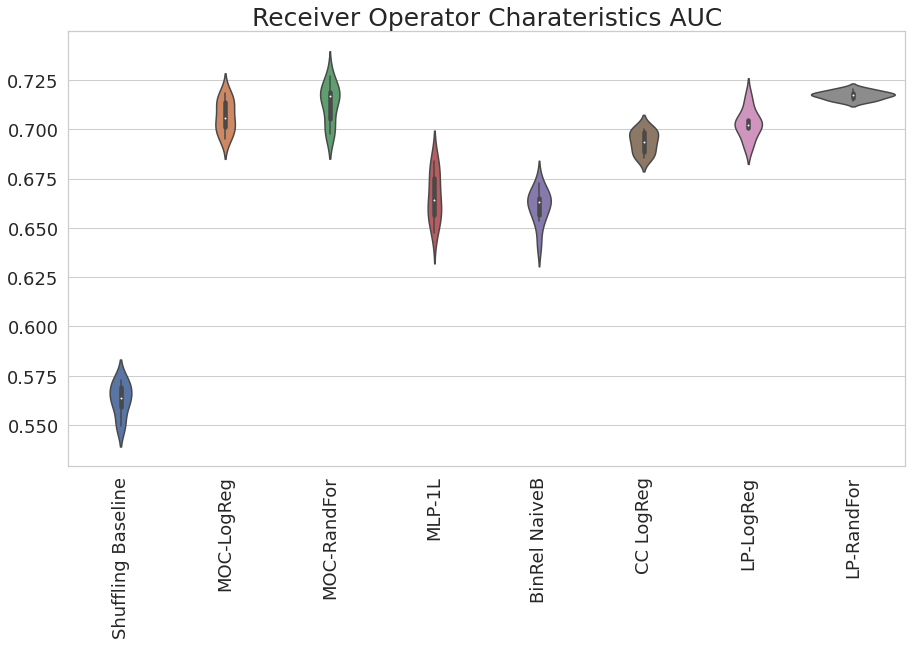

In [28]:

# plot
import seaborn as sns

sns.violinplot(y=roc_auc_all, x=model_names_all)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(15, 8)})
plt.title("Receiver Operator Charateristics AUC", fontsize = 25)
sns.set(style="whitegrid")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()